## Goal
#### Associated git sha of `vispz/numerai` github repo `11c74ffc`
In the notebook `task7b-ensembling-model-for-each-target`, we predicted using the models from each of the 36x3, `target x cv` split on the first half of the train+test split `test1`.  We will now use these prediction columns to and select the best target-models to ensemble on.


### Methodology
We will use 2 methods of feature selection
 * Elastic-Net
 * Recursive feature selection with shallow gbt.


#### Previous notebook saved data format
  ``` python
  {
      "cv_predcols_map": [
          ["pred_arthur_v4_20_cv0", "pred_nomi_v4_20_cv0", ...],  # cv 0
          ["pred_arthur_v4_20_cv1", "pred_nomi_v4_20_cv1", ...],  # cv 1
          ["pred_arthur_v4_20_cv2", "pred_nomi_v4_20_cv2", ...],  # cv 2
      ],
      "cv_to_val_test_map": [
          # cv 0
          {"val": pd.DataFrame([era, features, pred_cols]),
           "test": pd.DataFrame([era, features])},
          {"val": DF, "test": DF},  # cv 1
          {"val": DF, "test": DF},  # cv 2
          
      ]
  }
  ```

In [ ]:
%load_ext autoreload
%autoreload 2

from IPython.display import display, HTML, clear_output
display(HTML("<style>.container { width:100% !important; }</style>"))

from importlib import reload
import logging
reload(logging)
import logging
logging.basicConfig(level=logging.INFO)

import glob
import numpy as np
import datetime
import json
import os
import os.path
from os.path import join
import warnings
import flatdict
import pandas as pd
import mlflow
import gc
import functools
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.express as px
import plotly.offline as pyo
import itertools as it

import utils as ut

from pprint import pprint, pformat
from tqdm.notebook import tqdm

from utils import ERA_COL


pyo.init_notebook_mode()
pd.options.mode.chained_assignment = None  # default='warn'
# Filter the setuptools UserWarning until we stop relying on distutils
warnings.filterwarnings(
    "ignore",
    message="Setuptools is replacing distutils.",
    category=UserWarning,
    module="_distutils_hack",
)
DF = pd.DataFrame
sns.set_theme()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Constants

In [63]:
LOCAL = True
if LOCAL:
    ML_TRACKING_SERVER_URI = "http://127.0.0.1:5000"
    AWS_CREDENTIALS_FILE = "~/.aws/personal_credentials"
else:
    ML_TRACKING_SERVER_URI = "http://18.218.213.146:5500/"
    AWS_CREDENTIALS_FILE = "~/.aws/credentials"
EXPERIMENT_NAME = f"ensemble_tgts_for_cyrus_2023-04-26_19h-36m"
DATA_PATH = "./data/"
VAL_PRED_S3_PATH = (
    "s3://numerai-v1/experiments/"
    "ensemble_tgts_for_cyrus_2023-04-26_19h-36m/"
    "ckpt1_cv_val_preds.pkl"
)
expt_local_dir = os.path.join(DATA_PATH, "experiments", EXPERIMENT_NAME)
os.makedirs(expt_local_dir, exist_ok=True)
log = ut.Logger(root_dir="./")
log.info(f"{EXPERIMENT_NAME=}")
log.info(f"{VAL_PRED_S3_PATH=}")
log.info(f"{expt_local_dir=}")

[2023-04-27 00:31:34]  EXPERIMENT_NAME='ensemble_tgts_for_cyrus_2023-04-26_19h-36m'
[2023-04-27 00:31:34]  VAL_PRED_S3_PATH='s3://numerai-v1/experiments/ensemble_tgts_for_cyrus_2023-04-26_19h-36m/ckpt1_cv_val_preds.pkl'
[2023-04-27 00:31:34]  expt_local_dir='./data/experiments/ensemble_tgts_for_cyrus_2023-04-26_19h-36m'


## 2. Download data and load up the model predns on val data

In [66]:
mlflow.set_tracking_uri(ML_TRACKING_SERVER_URI)
try:
    cv_expt_id = mlflow.create_experiment(name=EXPERIMENT_NAME)
except Exception:
    cv_expt_id = mlflow.get_experiment_by_name(name=EXPERIMENT_NAME).experiment_id
log.info(f"{EXPERIMENT_NAME=}, {cv_expt_id=}")

[2023-04-27 00:32:04]  EXPERIMENT_NAME='ensemble_tgts_for_cyrus_2023-04-26_19h-36m', cv_expt_id='849708612397429268'


In [68]:
ut.download_s3_file(
    local_path=expt_local_dir,
    s3_path=VAL_PRED_S3_PATH,
    aws_credential_fl=AWS_CREDENTIALS_FILE,
)

[2023-04-27 00:36:32]  Loading aws credenitals from ~/.aws/personal_credentials...
[2023-04-27 00:36:32]  Downloading s3://numerai-v1/experiments/ensemble_tgts_for_cyrus_2023-04-26_19h-36m/ckpt1_cv_val_preds.pkl to ./data/experiments/ensemble_tgts_for_cyrus_2023-04-26_19h-36m/ckpt1_cv_val_preds.pkl


In [69]:
cv_valpreds = ut.unpickle_obj(fl=join(expt_local_dir, "ckpt1_cv_val_preds.pkl"))

In [118]:
split = 0
cv_valpreds["cv_to_val_test_map"][split]["val"][
    cv_valpreds["cv_predcols_map"][split]
].head()

,pred_target_arthur_v4_20_cv0,pred_target_arthur_v4_60_cv0,pred_target_thomas_v4_20_cv0,pred_target_thomas_v4_60_cv0,pred_target_cyrus_v4_20_cv0,pred_target_cyrus_v4_60_cv0,pred_target_caroline_v4_20_cv0,pred_target_caroline_v4_60_cv0,pred_target_sam_v4_20_cv0,pred_target_sam_v4_60_cv0,...,pred_target_ben_v4_20_cv0,pred_target_ben_v4_60_cv0,pred_target_alan_v4_20_cv0,pred_target_alan_v4_60_cv0,pred_target_paul_v4_20_cv0,pred_target_paul_v4_60_cv0,pred_target_george_v4_20_cv0,pred_target_george_v4_60_cv0,pred_target_william_v4_20_cv0,pred_target_william_v4_60_cv0
id,,,,,,,,,,,,,,,,,,,,,
n002a1e6fcba57c3,0.504404,0.507692,0.501433,0.511991,0.493194,0.499853,0.486156,0.499595,0.497060,0.490968,...,0.507701,0.522336,0.499912,0.513813,0.498872,0.505325,0.520370,0.539425,0.494268,0.497782
n004916b8479f44e,0.491408,0.500373,0.512815,0.522645,0.502384,0.489535,0.499766,0.484848,0.498851,0.497996,...,0.518919,0.535992,0.488364,0.498512,0.490213,0.489162,0.512241,0.495250,0.503878,0.497266
n004d16b87c34e80,0.501379,0.507177,0.504894,0.508452,0.507987,0.511606,0.501289,0.512012,0.508291,0.508380,...,0.497759,0.515989,0.498275,0.506099,0.510990,0.528794,0.515003,0.533349,0.516406,0.526430
n005c9cd0c6a7c85,0.500630,0.506156,0.500393,0.506846,0.508057,0.506606,0.510788,0.512265,0.503406,0.506401,...,0.500664,0.503580,0.503403,0.513874,0.498879,0.508784,0.495629,0.493829,0.506966,0.520383
n006d93e7ede20f6,0.487029,0.483808,0.501967,0.503810,0.507982,0.505617,0.512322,0.508200,0.500648,0.505810,...,0.496031,0.498428,0.482427,0.487855,0.455917,0.484383,0.464684,0.477696,0.485010,0.490067


In [119]:
cv_valpreds["cv_to_val_test_map"][split]["test"].head()

,feature_honoured_observational_balaamite,feature_polaroid_vadose_quinze,feature_untidy_withdrawn_bargeman,feature_genuine_kyphotic_trehala,feature_unenthralled_sportful_schoolhouse,feature_divulsive_explanatory_ideologue,feature_ichthyotic_roofed_yeshiva,feature_waggly_outlandish_carbonisation,feature_floriated_amish_sprite,feature_iconoclastic_parietal_agonist,...,target_cyrus_v4_20,target_cyrus_v4_60,target_caroline_v4_20,target_caroline_v4_60,target_sam_v4_20,target_sam_v4_60,target_xerxes_v4_20,target_xerxes_v4_60,era,data_type
id,,,,,,,,,,,,,,,,,,,,,
n00080f69dffdf1e,1,3,4,2,3,1,0,0,3,1,...,0.50,0.75,0.50,0.75,0.50,0.75,0.50,0.75,947,validation
n0024b48c9604def,2,0,3,1,3,2,1,3,0,3,...,0.75,0.75,0.75,0.75,0.75,0.75,0.75,0.75,947,validation
n00402ad0a1537a0,2,2,1,2,2,3,0,3,3,3,...,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.50,947,validation
n005349df1f118ce,4,0,4,0,2,2,4,0,1,2,...,0.50,0.25,0.50,0.25,0.50,0.25,0.50,0.25,947,validation
n005b52ad6f9ab1c,4,0,4,4,3,2,4,2,3,0,...,0.25,0.00,0.00,0.00,0.00,0.00,0.25,0.00,947,validation


## 3. Elastic net, cross-val $\alpha$ and $L1_{ratio}$

In [143]:
import sklearn.linear_model as sklin
import sklearn.base as skbase
import sklearn.model_selection
import time

from utils import TARGET_COL
log.info(TARGET_COL)

[2023-04-27 08:44:30]  target_cyrus_v4_20


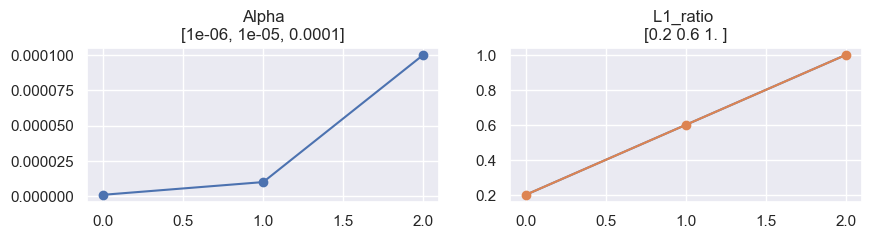

In [239]:
alphas = 10. ** np.arange(-6 ,-3)
l1_ratios = np.linspace(0.2, 1, 3)
plt.subplots(1,2, figsize=(10,2))
plt.subplot(121)
plt.plot(alphas, marker='o')
plt.title(f"Alpha\n{np.round(alphas, 6).tolist()}")
plt.subplot(122)
plt.plot(l1_ratios)
plt.plot(l1_ratios, marker='o')
plt.title(f"L1_ratio \n{l1_ratios}");

In [241]:
en_hps = list(it.product(alphas, l1_ratios))
en_hp_settings = [
    dict(alpha=alpha, l1_ratio=l1_ratio)
    for alpha, l1_ratio in en_hps
]
num_hp = len(en_hp_settings)
log.info(f"Elastic net hyperparam settings:\n{pformat(en_hp_settings)}")

[2023-04-27 09:52:58]  Elastic net hyperparam settings:
[{'alpha': 1e-06, 'l1_ratio': 0.2},
 {'alpha': 1e-06, 'l1_ratio': 0.6000000000000001},
 {'alpha': 1e-06, 'l1_ratio': 1.0},
 {'alpha': 1e-05, 'l1_ratio': 0.2},
 {'alpha': 1e-05, 'l1_ratio': 0.6000000000000001},
 {'alpha': 1e-05, 'l1_ratio': 1.0},
 {'alpha': 0.0001, 'l1_ratio': 0.2},
 {'alpha': 0.0001, 'l1_ratio': 0.6000000000000001},
 {'alpha': 0.0001, 'l1_ratio': 1.0}]


### 3.1 Compute baseline metrics which is simply taking the average

In [324]:
def score_baselines(
    cv_valpreds,
    predcols_subset=None,
    agg_fn=np.mean,
    baseline_name="",
):
    """
    :param predcols_subset: This could be a partial name like ['arthur_v4_20', 'nomi_v4_60']
    """
    cv = len(cv_valpreds["cv_predcols_map"])
    # xval metrics, xval ensemble columns, xval prediction value describe
    bl_cv_metrics, bl_cv_predcols, cv_pred_descs = [], [], []
    for split, predcols, val_test_map in tqdm(
        zip(
            range(cv),
            cv_valpreds["cv_predcols_map"],
            cv_valpreds["cv_to_val_test_map"],
        ),
        desc="CV split",
        total=cv,
    ):
        ########################## TODO  ##########################
        # train_df, test_df = val_test_map["val"], val_test_map["test"]
        val_df = val_test_map["val"]
        train_ix, test_ix = next(ut.time_series_split(val_df, n_splits=1, embargo=12))
        train_df, test_df = val_df.iloc[train_ix], val_df.iloc[test_ix]
        ###########################################################
        log.info(
            f"{split=}, {train_df[predcols].shape=}, {train_df.era.min()=}, "
            f"{train_df.era.max()=}, {train_df.era.nunique()=}",
        )
        ensmbl_predcol = f"ensemble_{baseline_name}_cv{split}"
        if predcols_subset is None:
            chosen_fts = predcols
        else:
            chosen_fts = [
                pcol for pcol in predcols
                if any(partial in pcol for partial in predcols_subset)
            ]
        log.info(f"Chosen {len(chosen_fts)} features: \n{chosen_fts}")
        test_df[ensmbl_predcol] = agg_fn(test_df[chosen_fts], axis=1)
        bl_cv_metrics.append(
            ut.validation_metrics(
                validation_data=test_df, pred_cols=[ensmbl_predcol], target_col=TARGET_COL
            ),
        )
        cv_pred_descs.append(test_df[ensmbl_predcol].describe())
    log.info("Prediction distribution")
    display(pd.concat(cv_pred_descs, axis=1))
    baseline_metrics = ut.to_cv_agg_df(bl_cv_metrics)
    display(ut.fmt_metrics_df(baseline_metrics))
    return baseline_metrics

In [326]:
bl_allpred_mean_metrics = score_baselines(
    cv_valpreds=cv_valpreds,
    predcols_subset=None,
    agg_fn=np.mean,
    baseline_name="allpreds_mean",
)

CV split:   0%|          | 0/3 [00:00<?, ?it/s]

[2023-04-27 10:52:28]  split=0, train_df[predcols].shape=(290880, 36), train_df.era.min()=819, train_df.era.max()=876, train_df.era.nunique()=58
[2023-04-27 10:52:28]  Chosen 36 features: 
['pred_target_arthur_v4_20_cv0', 'pred_target_arthur_v4_60_cv0', 'pred_target_thomas_v4_20_cv0', 'pred_target_thomas_v4_60_cv0', 'pred_target_cyrus_v4_20_cv0', 'pred_target_cyrus_v4_60_cv0', 'pred_target_caroline_v4_20_cv0', 'pred_target_caroline_v4_60_cv0', 'pred_target_sam_v4_20_cv0', 'pred_target_sam_v4_60_cv0', 'pred_target_xerxes_v4_20_cv0', 'pred_target_xerxes_v4_60_cv0', 'pred_target_nomi_v4_20_cv0', 'pred_target_nomi_v4_60_cv0', 'pred_target_tyler_v4_20_cv0', 'pred_target_tyler_v4_60_cv0', 'pred_target_victor_v4_20_cv0', 'pred_target_victor_v4_60_cv0', 'pred_target_ralph_v4_20_cv0', 'pred_target_ralph_v4_60_cv0', 'pred_target_waldo_v4_20_cv0', 'pred_target_waldo_v4_60_cv0', 'pred_target_jerome_v4_20_cv0', 'pred_target_jerome_v4_60_cv0', 'pred_target_janet_v4_20_cv0', 'pred_target_janet_v4_60_

,ensemble_allpreds_mean_cv0,ensemble_allpreds_mean_cv1,ensemble_allpreds_mean_cv2
count,235099.000000,228895.000000,207089.000000
mean,0.500167,0.501381,0.501247
std,0.016192,0.019057,0.026184
min,0.404401,0.405759,0.359062
25%,0.489816,0.489041,0.484490
50%,0.500168,0.501172,0.501230
75%,0.510631,0.513605,0.517862
max,0.575366,0.600380,0.622512


,mean,std,sharpe
ensemble_allpreds_mean_cv0,2.22%,2.14%,103.57%
ensemble_allpreds_mean_cv1,3.43%,1.64%,208.59%
ensemble_allpreds_mean_cv2,2.71%,1.19%,227.44%
cv_mean,2.78%,1.66%,179.87%
cv_low,2.09%,1.12%,104.34%
cv_high,3.47%,2.20%,255.39%
cv_std,0.61%,0.48%,66.74%


In [327]:
bl_allpred_mean_metrics = score_baselines(
    cv_valpreds=cv_valpreds,
    predcols_subset=[
    "target_cyrus_v4_20",
    "target_ralph_v4_20",
    "target_sam_v4_20",
    "target_xerxes_v4_20",
    "target_caroline_v4_20",
    "target_waldo_v4_20",
    "target_nomi_v4_20",
    "target_tyler_v4_20",
    ],
    agg_fn=np.mean,
    baseline_name="allpreds_mean",
)

CV split:   0%|          | 0/3 [00:00<?, ?it/s]

[2023-04-27 10:54:43]  split=0, train_df[predcols].shape=(290880, 36), train_df.era.min()=819, train_df.era.max()=876, train_df.era.nunique()=58
[2023-04-27 10:54:43]  Chosen 8 features: 
['pred_target_cyrus_v4_20_cv0', 'pred_target_caroline_v4_20_cv0', 'pred_target_sam_v4_20_cv0', 'pred_target_xerxes_v4_20_cv0', 'pred_target_nomi_v4_20_cv0', 'pred_target_tyler_v4_20_cv0', 'pred_target_ralph_v4_20_cv0', 'pred_target_waldo_v4_20_cv0']
[2023-04-27 10:54:48]  split=1, train_df[predcols].shape=(282781, 36), train_df.era.min()=555, train_df.era.max()=612, train_df.era.nunique()=58
[2023-04-27 10:54:48]  Chosen 8 features: 
['pred_target_cyrus_v4_20_cv1', 'pred_target_caroline_v4_20_cv1', 'pred_target_sam_v4_20_cv1', 'pred_target_xerxes_v4_20_cv1', 'pred_target_nomi_v4_20_cv1', 'pred_target_tyler_v4_20_cv1', 'pred_target_ralph_v4_20_cv1', 'pred_target_waldo_v4_20_cv1']
[2023-04-27 10:54:54]  split=2, train_df[predcols].shape=(245575, 36), train_df.era.min()=291, train_df.era.max()=349, train

,ensemble_allpreds_mean_cv0,ensemble_allpreds_mean_cv1,ensemble_allpreds_mean_cv2
count,235099.000000,228895.000000,207089.000000
mean,0.500079,0.500791,0.500768
std,0.015211,0.018099,0.024328
min,0.421268,0.416300,0.378706
25%,0.490123,0.488752,0.484934
50%,0.499704,0.500133,0.500125
75%,0.509743,0.512180,0.515788
max,0.586114,0.587002,0.643632


,mean,std,sharpe
ensemble_allpreds_mean_cv0,2.23%,2.22%,100.45%
ensemble_allpreds_mean_cv1,3.81%,1.65%,230.87%
ensemble_allpreds_mean_cv2,3.18%,1.29%,245.34%
cv_mean,3.07%,1.72%,192.22%
cv_low,2.17%,1.19%,101.91%
cv_high,3.97%,2.25%,282.52%
cv_std,0.79%,0.47%,79.80%


### 3.2 Elastic net hyperparam search

In [334]:
cv = len(cv_valpreds["cv_predcols_map"])
# mapping like so
# [
#    {"hp": {"alpha": 0.1, "l1_ratio": 1.}, "cv_models": [m0, m1, m2],
#     "cv_metrics": [m0df, m1df, m2df]}, "cv_cols": ["ensemble_alpha_0.1_l1_ratio_1._cv0", ...]
# ]
hp_cv_models = []
for i, hp_dict in tqdm(enumerate(en_hp_settings), total=len(en_hp_settings), desc="Hyperparam setting"):
    log.info(f"\nHyperparam settings {i+1}/{num_hp}: {hp_dict}")
    ensmbl_cv_models, ensmbl_cv_predcols, ensmbl_cv_metrics, cv_pred_descs = [], [], [], []
    for split, predcols, val_test_map in tqdm(
        zip(
            range(cv),
            cv_valpreds["cv_predcols_map"],
            cv_valpreds["cv_to_val_test_map"],
        ),
        desc="CV split",
        total=cv,
    ):
        train_st_tm = time.time()
        if split == 0:
            prev_split_mdl = split_mdl = sklin.ElasticNet(
                warm_start=True, random_state=42, fit_intercept=True,
                max_iter=3000, **hp_dict,
            )
        else:
            # Start from previous split's converged value for faster convergence
            split_mdl = skbase.clone(prev_split_mdl)
        ########################## TODO  ##########################
        # train_df, test_df = val_test_map["val"], val_test_map["test"]
        val_df = val_test_map["val"]
        train_ix, test_ix = next(ut.time_series_split(val_df, n_splits=1, embargo=12))
        train_df, test_df = val_df.iloc[train_ix], val_df.iloc[test_ix]
        log.info(
            f"{split=}, {train_df[predcols].shape=}, {train_df.era.min()=}, "
            f"{train_df.era.max()=}, {train_df.era.nunique()=}",
        )
        ###########################################################
        # We don't have to filter out NAs as cyrus doesn't have NA values.
        split_mdl.fit(X=train_df[predcols], y=train_df[TARGET_COL])
        hp_title = "".join(f"_{hp_nm}_{hp_val}" for hp_nm, hp_val in hp_dict.items())
        ensmbl_predcol = f"ensemble_{hp_title}__cv{split}"
        log.info(f"Predicting column: {ensmbl_predcol}")
        test_df[ensmbl_predcol] = split_mdl.predict(X=test_df[predcols])
        metrics_df = ut.validation_metrics(
            validation_data=test_df, pred_cols=[ensmbl_predcol], target_col=TARGET_COL
        )
        z_coef = prev_split_mdl.coef_==0
        log.info(f"Percent of zero columns: {z_coef.mean():.0%} ({z_coef.sum()}/{len(z_coef)})")
        log.info(f"Training time: {(time.time() - train_st_tm):.0f} seconds\n")
        # collect data for saving
        ensmbl_cv_models.append(split_mdl)
        ensmbl_cv_predcols.append(ensmbl_predcol)
        ensmbl_cv_metrics.append(metrics_df)
        cv_pred_descs.append(test_df[ensmbl_predcol].describe())
    log.info("Prediction distribution")
    display(pd.concat(cv_pred_descs, axis=1))
    hp_cv_models.append(
        {
            "hp": hp_dict,
            "cv_models": ensmbl_cv_models,
            "cv_pred_cols": ensmbl_cv_predcols,
            "cv_metrics": ut.to_cv_agg_df(ensmbl_cv_metrics),
        },
    )
    display(ut.fmt_metrics_df(hp_cv_models[-1]["cv_metrics"]))

Hyperparam setting:   0%|          | 0/9 [00:00<?, ?it/s]

[2023-04-27 11:02:32]  
Hyperparam settings 1/9: {'alpha': 1e-06, 'l1_ratio': 0.2}


CV split:   0%|          | 0/3 [00:00<?, ?it/s]

[2023-04-27 11:02:34]  split=0, train_df[predcols].shape=(290880, 36), train_df.era.min()=819, train_df.era.max()=876, train_df.era.nunique()=58
[2023-04-27 11:02:43]  Predicting column: ensemble__alpha_1e-06_l1_ratio_0.2__cv0
[2023-04-27 11:02:43]  Percent of zero columns: 6% (2/36)
[2023-04-27 11:02:43]  Training time: 12 seconds

[2023-04-27 11:02:49]  split=1, train_df[predcols].shape=(282781, 36), train_df.era.min()=555, train_df.era.max()=612, train_df.era.nunique()=58
[2023-04-27 11:02:57]  Predicting column: ensemble__alpha_1e-06_l1_ratio_0.2__cv1
[2023-04-27 11:02:58]  Percent of zero columns: 6% (2/36)
[2023-04-27 11:02:58]  Training time: 14 seconds

[2023-04-27 11:03:05]  split=2, train_df[predcols].shape=(245575, 36), train_df.era.min()=291, train_df.era.max()=349, train_df.era.nunique()=59
[2023-04-27 11:03:11]  Predicting column: ensemble__alpha_1e-06_l1_ratio_0.2__cv2
[2023-04-27 11:03:12]  Percent of zero columns: 6% (2/36)
[2023-04-27 11:03:12]  Training time: 14 seco

,ensemble__alpha_1e-06_l1_ratio_0.2__cv0,ensemble__alpha_1e-06_l1_ratio_0.2__cv1,ensemble__alpha_1e-06_l1_ratio_0.2__cv2
count,235099.000000,228895.000000,207089.000000
mean,0.500297,0.500215,0.500022
std,0.007939,0.010511,0.009228
min,0.458681,0.438164,0.454914
25%,0.495118,0.493447,0.493982
50%,0.500166,0.500013,0.500001
75%,0.505392,0.506871,0.506041
max,0.540198,0.554525,0.541674


,mean,std,sharpe
ensemble__alpha_1e-06_l1_ratio_0.2__cv0,2.56%,1.66%,154.12%
ensemble__alpha_1e-06_l1_ratio_0.2__cv1,3.45%,1.93%,179.21%
ensemble__alpha_1e-06_l1_ratio_0.2__cv2,2.93%,1.36%,215.17%
cv_mean,2.98%,1.65%,182.83%
cv_low,2.47%,1.33%,148.10%
cv_high,3.49%,1.97%,217.56%
cv_std,0.45%,0.28%,30.69%


[2023-04-27 11:03:12]  
Hyperparam settings 2/9: {'alpha': 1e-06, 'l1_ratio': 0.6000000000000001}


CV split:   0%|          | 0/3 [00:00<?, ?it/s]

[2023-04-27 11:03:19]  split=0, train_df[predcols].shape=(290880, 36), train_df.era.min()=819, train_df.era.max()=876, train_df.era.nunique()=58
[2023-04-27 11:03:25]  Predicting column: ensemble__alpha_1e-06_l1_ratio_0.6000000000000001__cv0
[2023-04-27 11:03:25]  Percent of zero columns: 11% (4/36)
[2023-04-27 11:03:25]  Training time: 13 seconds

[2023-04-27 11:03:32]  split=1, train_df[predcols].shape=(282781, 36), train_df.era.min()=555, train_df.era.max()=612, train_df.era.nunique()=58
[2023-04-27 11:03:37]  Predicting column: ensemble__alpha_1e-06_l1_ratio_0.6000000000000001__cv1
[2023-04-27 11:03:38]  Percent of zero columns: 11% (4/36)
[2023-04-27 11:03:38]  Training time: 13 seconds

[2023-04-27 11:03:42]  split=2, train_df[predcols].shape=(245575, 36), train_df.era.min()=291, train_df.era.max()=349, train_df.era.nunique()=59
[2023-04-27 11:03:47]  Predicting column: ensemble__alpha_1e-06_l1_ratio_0.6000000000000001__cv2
[2023-04-27 11:03:48]  Percent of zero columns: 11% (4/3

,ensemble__alpha_1e-06_l1_ratio_0.6000000000000001__cv0,ensemble__alpha_1e-06_l1_ratio_0.6000000000000001__cv1,ensemble__alpha_1e-06_l1_ratio_0.6000000000000001__cv2
count,235099.000000,228895.000000,207089.000000
mean,0.500289,0.500218,0.500023
std,0.007795,0.010438,0.009143
min,0.459591,0.438917,0.455559
25%,0.495200,0.493498,0.494046
50%,0.500161,0.500010,0.499996
75%,0.505284,0.506814,0.505982
max,0.539263,0.554174,0.541041


,mean,std,sharpe
ensemble__alpha_1e-06_l1_ratio_0.6000000000000001__cv0,2.56%,1.68%,152.61%
ensemble__alpha_1e-06_l1_ratio_0.6000000000000001__cv1,3.49%,1.92%,181.10%
ensemble__alpha_1e-06_l1_ratio_0.6000000000000001__cv2,2.95%,1.37%,215.51%
cv_mean,3.00%,1.66%,183.07%
cv_low,2.47%,1.34%,147.43%
cv_high,3.52%,1.97%,218.71%
cv_std,0.47%,0.28%,31.50%


[2023-04-27 11:03:48]  
Hyperparam settings 3/9: {'alpha': 1e-06, 'l1_ratio': 1.0}


CV split:   0%|          | 0/3 [00:00<?, ?it/s]

[2023-04-27 11:03:53]  split=0, train_df[predcols].shape=(290880, 36), train_df.era.min()=819, train_df.era.max()=876, train_df.era.nunique()=58
[2023-04-27 11:03:57]  Predicting column: ensemble__alpha_1e-06_l1_ratio_1.0__cv0
[2023-04-27 11:03:58]  Percent of zero columns: 11% (4/36)
[2023-04-27 11:03:58]  Training time: 10 seconds

[2023-04-27 11:04:02]  split=1, train_df[predcols].shape=(282781, 36), train_df.era.min()=555, train_df.era.max()=612, train_df.era.nunique()=58
[2023-04-27 11:04:07]  Predicting column: ensemble__alpha_1e-06_l1_ratio_1.0__cv1
[2023-04-27 11:04:08]  Percent of zero columns: 11% (4/36)
[2023-04-27 11:04:08]  Training time: 10 seconds

[2023-04-27 11:04:15]  split=2, train_df[predcols].shape=(245575, 36), train_df.era.min()=291, train_df.era.max()=349, train_df.era.nunique()=59
[2023-04-27 11:04:18]  Predicting column: ensemble__alpha_1e-06_l1_ratio_1.0__cv2
[2023-04-27 11:04:19]  Percent of zero columns: 11% (4/36)
[2023-04-27 11:04:19]  Training time: 11 s

,ensemble__alpha_1e-06_l1_ratio_1.0__cv0,ensemble__alpha_1e-06_l1_ratio_1.0__cv1,ensemble__alpha_1e-06_l1_ratio_1.0__cv2
count,235099.000000,228895.000000,207089.000000
mean,0.500283,0.500221,0.500025
std,0.007658,0.010373,0.009061
min,0.460597,0.439722,0.456220
25%,0.495287,0.493538,0.494095
50%,0.500154,0.500007,0.499989
75%,0.505191,0.506763,0.505931
max,0.538574,0.554173,0.540836


,mean,std,sharpe
ensemble__alpha_1e-06_l1_ratio_1.0__cv0,2.57%,1.70%,151.68%
ensemble__alpha_1e-06_l1_ratio_1.0__cv1,3.51%,1.93%,182.44%
ensemble__alpha_1e-06_l1_ratio_1.0__cv2,2.96%,1.37%,215.76%
cv_mean,3.01%,1.66%,183.29%
cv_low,2.48%,1.35%,147.03%
cv_high,3.55%,1.98%,219.56%
cv_std,0.47%,0.28%,32.05%


[2023-04-27 11:04:19]  
Hyperparam settings 4/9: {'alpha': 1e-05, 'l1_ratio': 0.2}


CV split:   0%|          | 0/3 [00:00<?, ?it/s]

[2023-04-27 11:04:24]  split=0, train_df[predcols].shape=(290880, 36), train_df.era.min()=819, train_df.era.max()=876, train_df.era.nunique()=58
[2023-04-27 11:04:26]  Predicting column: ensemble__alpha_1e-05_l1_ratio_0.2__cv0
[2023-04-27 11:04:27]  Percent of zero columns: 22% (8/36)
[2023-04-27 11:04:27]  Training time: 8 seconds

[2023-04-27 11:04:32]  split=1, train_df[predcols].shape=(282781, 36), train_df.era.min()=555, train_df.era.max()=612, train_df.era.nunique()=58
[2023-04-27 11:04:36]  Predicting column: ensemble__alpha_1e-05_l1_ratio_0.2__cv1
[2023-04-27 11:04:36]  Percent of zero columns: 22% (8/36)
[2023-04-27 11:04:36]  Training time: 9 seconds

[2023-04-27 11:04:41]  split=2, train_df[predcols].shape=(245575, 36), train_df.era.min()=291, train_df.era.max()=349, train_df.era.nunique()=59
[2023-04-27 11:04:43]  Predicting column: ensemble__alpha_1e-05_l1_ratio_0.2__cv2
[2023-04-27 11:04:44]  Percent of zero columns: 22% (8/36)
[2023-04-27 11:04:44]  Training time: 7 seco

,ensemble__alpha_1e-05_l1_ratio_0.2__cv0,ensemble__alpha_1e-05_l1_ratio_0.2__cv1,ensemble__alpha_1e-05_l1_ratio_0.2__cv2
count,235099.000000,228895.000000,207089.000000
mean,0.500270,0.500234,0.500045
std,0.006947,0.010076,0.008723
min,0.465468,0.443163,0.456658
25%,0.495748,0.493753,0.494334
50%,0.500169,0.500019,0.500002
75%,0.504701,0.506599,0.505740
max,0.535664,0.551871,0.538909


,mean,std,sharpe
ensemble__alpha_1e-05_l1_ratio_0.2__cv0,2.62%,1.83%,143.33%
ensemble__alpha_1e-05_l1_ratio_0.2__cv1,3.62%,1.88%,192.30%
ensemble__alpha_1e-05_l1_ratio_0.2__cv2,2.99%,1.37%,217.72%
cv_mean,3.08%,1.70%,184.45%
cv_low,2.51%,1.38%,141.66%
cv_high,3.65%,2.01%,227.23%
cv_std,0.50%,0.28%,37.81%


[2023-04-27 11:04:44]  
Hyperparam settings 5/9: {'alpha': 1e-05, 'l1_ratio': 0.6000000000000001}


CV split:   0%|          | 0/3 [00:00<?, ?it/s]

[2023-04-27 11:04:49]  split=0, train_df[predcols].shape=(290880, 36), train_df.era.min()=819, train_df.era.max()=876, train_df.era.nunique()=58
[2023-04-27 11:04:49]  Predicting column: ensemble__alpha_1e-05_l1_ratio_0.6000000000000001__cv0
[2023-04-27 11:04:50]  Percent of zero columns: 69% (25/36)
[2023-04-27 11:04:50]  Training time: 6 seconds

[2023-04-27 11:04:55]  split=1, train_df[predcols].shape=(282781, 36), train_df.era.min()=555, train_df.era.max()=612, train_df.era.nunique()=58
[2023-04-27 11:04:56]  Predicting column: ensemble__alpha_1e-05_l1_ratio_0.6000000000000001__cv1
[2023-04-27 11:04:57]  Percent of zero columns: 69% (25/36)
[2023-04-27 11:04:57]  Training time: 7 seconds

[2023-04-27 11:05:04]  split=2, train_df[predcols].shape=(245575, 36), train_df.era.min()=291, train_df.era.max()=349, train_df.era.nunique()=59
[2023-04-27 11:05:07]  Predicting column: ensemble__alpha_1e-05_l1_ratio_0.6000000000000001__cv2
[2023-04-27 11:05:07]  Percent of zero columns: 69% (25/

,ensemble__alpha_1e-05_l1_ratio_0.6000000000000001__cv0,ensemble__alpha_1e-05_l1_ratio_0.6000000000000001__cv1,ensemble__alpha_1e-05_l1_ratio_0.6000000000000001__cv2
count,235099.000000,228895.000000,207089.000000
mean,0.500241,0.500243,0.500067
std,0.006401,0.009694,0.008233
min,0.465038,0.444971,0.458284
25%,0.496131,0.494071,0.494698
50%,0.500164,0.500018,0.500014
75%,0.504231,0.506299,0.505446
max,0.535072,0.549957,0.537506


,mean,std,sharpe
ensemble__alpha_1e-05_l1_ratio_0.6000000000000001__cv0,2.49%,2.00%,124.71%
ensemble__alpha_1e-05_l1_ratio_0.6000000000000001__cv1,3.68%,1.82%,202.49%
ensemble__alpha_1e-05_l1_ratio_0.6000000000000001__cv2,3.02%,1.41%,214.26%
cv_mean,3.06%,1.74%,180.49%
cv_low,2.39%,1.40%,125.42%
cv_high,3.74%,2.08%,235.55%
cv_std,0.60%,0.30%,48.66%


[2023-04-27 11:05:08]  
Hyperparam settings 6/9: {'alpha': 1e-05, 'l1_ratio': 1.0}


CV split:   0%|          | 0/3 [00:00<?, ?it/s]

[2023-04-27 11:05:17]  split=0, train_df[predcols].shape=(290880, 36), train_df.era.min()=819, train_df.era.max()=876, train_df.era.nunique()=58
[2023-04-27 11:05:18]  Predicting column: ensemble__alpha_1e-05_l1_ratio_1.0__cv0
[2023-04-27 11:05:19]  Percent of zero columns: 69% (25/36)
[2023-04-27 11:05:19]  Training time: 11 seconds

[2023-04-27 11:05:24]  split=1, train_df[predcols].shape=(282781, 36), train_df.era.min()=555, train_df.era.max()=612, train_df.era.nunique()=58
[2023-04-27 11:05:27]  Predicting column: ensemble__alpha_1e-05_l1_ratio_1.0__cv1
[2023-04-27 11:05:28]  Percent of zero columns: 69% (25/36)
[2023-04-27 11:05:28]  Training time: 9 seconds

[2023-04-27 11:05:32]  split=2, train_df[predcols].shape=(245575, 36), train_df.era.min()=291, train_df.era.max()=349, train_df.era.nunique()=59
[2023-04-27 11:05:33]  Predicting column: ensemble__alpha_1e-05_l1_ratio_1.0__cv2
[2023-04-27 11:05:34]  Percent of zero columns: 69% (25/36)
[2023-04-27 11:05:34]  Training time: 6 

,ensemble__alpha_1e-05_l1_ratio_1.0__cv0,ensemble__alpha_1e-05_l1_ratio_1.0__cv1,ensemble__alpha_1e-05_l1_ratio_1.0__cv2
count,235099.000000,228895.000000,207089.000000
mean,0.500226,0.500240,0.500114
std,0.006068,0.009410,0.007879
min,0.465050,0.445607,0.460490
25%,0.496368,0.494302,0.494965
50%,0.500142,0.500010,0.500058
75%,0.503996,0.506046,0.505265
max,0.533691,0.548266,0.537426


,mean,std,sharpe
ensemble__alpha_1e-05_l1_ratio_1.0__cv0,2.44%,2.06%,118.47%
ensemble__alpha_1e-05_l1_ratio_1.0__cv1,3.70%,1.78%,207.62%
ensemble__alpha_1e-05_l1_ratio_1.0__cv2,3.02%,1.41%,214.61%
cv_mean,3.06%,1.75%,180.23%
cv_low,2.34%,1.38%,119.57%
cv_high,3.77%,2.12%,240.89%
cv_std,0.63%,0.33%,53.60%


[2023-04-27 11:05:34]  
Hyperparam settings 7/9: {'alpha': 0.0001, 'l1_ratio': 0.2}


CV split:   0%|          | 0/3 [00:00<?, ?it/s]

[2023-04-27 11:05:39]  split=0, train_df[predcols].shape=(290880, 36), train_df.era.min()=819, train_df.era.max()=876, train_df.era.nunique()=58
[2023-04-27 11:05:40]  Predicting column: ensemble__alpha_0.0001_l1_ratio_0.2__cv0
[2023-04-27 11:05:40]  Percent of zero columns: 64% (23/36)
[2023-04-27 11:05:40]  Training time: 7 seconds

[2023-04-27 11:05:46]  split=1, train_df[predcols].shape=(282781, 36), train_df.era.min()=555, train_df.era.max()=612, train_df.era.nunique()=58
[2023-04-27 11:05:47]  Predicting column: ensemble__alpha_0.0001_l1_ratio_0.2__cv1
[2023-04-27 11:05:47]  Percent of zero columns: 64% (23/36)
[2023-04-27 11:05:47]  Training time: 7 seconds

[2023-04-27 11:05:51]  split=2, train_df[predcols].shape=(245575, 36), train_df.era.min()=291, train_df.era.max()=349, train_df.era.nunique()=59
[2023-04-27 11:05:52]  Predicting column: ensemble__alpha_0.0001_l1_ratio_0.2__cv2
[2023-04-27 11:05:53]  Percent of zero columns: 64% (23/36)
[2023-04-27 11:05:53]  Training time: 

,ensemble__alpha_0.0001_l1_ratio_0.2__cv0,ensemble__alpha_0.0001_l1_ratio_0.2__cv1,ensemble__alpha_0.0001_l1_ratio_0.2__cv2
count,235099.000000,228895.000000,207089.000000
mean,0.500165,0.500229,0.500216
std,0.005132,0.008435,0.006735
min,0.470031,0.454363,0.466308
25%,0.496906,0.494821,0.495795
50%,0.500060,0.500040,0.500145
75%,0.503354,0.505499,0.504577
max,0.527160,0.542555,0.534590


,mean,std,sharpe
ensemble__alpha_0.0001_l1_ratio_0.2__cv0,2.45%,2.09%,117.20%
ensemble__alpha_0.0001_l1_ratio_0.2__cv1,3.76%,1.76%,213.20%
ensemble__alpha_0.0001_l1_ratio_0.2__cv2,3.20%,1.37%,233.24%
cv_mean,3.14%,1.74%,187.88%
cv_low,2.39%,1.34%,117.69%
cv_high,3.88%,2.15%,258.07%
cv_std,0.66%,0.36%,62.03%


[2023-04-27 11:05:53]  
Hyperparam settings 8/9: {'alpha': 0.0001, 'l1_ratio': 0.6000000000000001}


CV split:   0%|          | 0/3 [00:00<?, ?it/s]

[2023-04-27 11:05:58]  split=0, train_df[predcols].shape=(290880, 36), train_df.era.min()=819, train_df.era.max()=876, train_df.era.nunique()=58
[2023-04-27 11:05:58]  Predicting column: ensemble__alpha_0.0001_l1_ratio_0.6000000000000001__cv0
[2023-04-27 11:05:59]  Percent of zero columns: 83% (30/36)
[2023-04-27 11:05:59]  Training time: 6 seconds

[2023-04-27 11:06:05]  split=1, train_df[predcols].shape=(282781, 36), train_df.era.min()=555, train_df.era.max()=612, train_df.era.nunique()=58
[2023-04-27 11:06:05]  Predicting column: ensemble__alpha_0.0001_l1_ratio_0.6000000000000001__cv1
[2023-04-27 11:06:06]  Percent of zero columns: 83% (30/36)
[2023-04-27 11:06:06]  Training time: 7 seconds

[2023-04-27 11:06:11]  split=2, train_df[predcols].shape=(245575, 36), train_df.era.min()=291, train_df.era.max()=349, train_df.era.nunique()=59
[2023-04-27 11:06:11]  Predicting column: ensemble__alpha_0.0001_l1_ratio_0.6000000000000001__cv2
[2023-04-27 11:06:11]  Percent of zero columns: 83% (

,ensemble__alpha_0.0001_l1_ratio_0.6000000000000001__cv0,ensemble__alpha_0.0001_l1_ratio_0.6000000000000001__cv1,ensemble__alpha_0.0001_l1_ratio_0.6000000000000001__cv2
count,235099.000000,228895.000000,207089.000000
mean,0.500051,0.500154,0.500242
std,0.003095,0.006419,0.004998
min,0.482622,0.465417,0.474987
25%,0.498072,0.496016,0.496988
50%,0.499982,0.500002,0.500164
75%,0.501957,0.504160,0.503404
max,0.516803,0.533419,0.526786


,mean,std,sharpe
ensemble__alpha_0.0001_l1_ratio_0.6000000000000001__cv0,2.31%,2.05%,112.29%
ensemble__alpha_0.0001_l1_ratio_0.6000000000000001__cv1,3.71%,1.78%,207.85%
ensemble__alpha_0.0001_l1_ratio_0.6000000000000001__cv2,3.08%,1.34%,228.98%
cv_mean,3.03%,1.73%,183.04%
cv_low,2.24%,1.32%,112.68%
cv_high,3.82%,2.13%,253.40%
cv_std,0.70%,0.36%,62.18%


[2023-04-27 11:06:11]  
Hyperparam settings 9/9: {'alpha': 0.0001, 'l1_ratio': 1.0}


CV split:   0%|          | 0/3 [00:00<?, ?it/s]

[2023-04-27 11:06:17]  split=0, train_df[predcols].shape=(290880, 36), train_df.era.min()=819, train_df.era.max()=876, train_df.era.nunique()=58
[2023-04-27 11:06:17]  Predicting column: ensemble__alpha_0.0001_l1_ratio_1.0__cv0
[2023-04-27 11:06:18]  Percent of zero columns: 94% (34/36)
[2023-04-27 11:06:18]  Training time: 6 seconds

[2023-04-27 11:06:24]  split=1, train_df[predcols].shape=(282781, 36), train_df.era.min()=555, train_df.era.max()=612, train_df.era.nunique()=58
[2023-04-27 11:06:24]  Predicting column: ensemble__alpha_0.0001_l1_ratio_1.0__cv1
[2023-04-27 11:06:25]  Percent of zero columns: 94% (34/36)
[2023-04-27 11:06:25]  Training time: 7 seconds

[2023-04-27 11:06:36]  split=2, train_df[predcols].shape=(245575, 36), train_df.era.min()=291, train_df.era.max()=349, train_df.era.nunique()=59
[2023-04-27 11:06:36]  Predicting column: ensemble__alpha_0.0001_l1_ratio_1.0__cv2
[2023-04-27 11:06:37]  Percent of zero columns: 94% (34/36)
[2023-04-27 11:06:37]  Training time: 

,ensemble__alpha_0.0001_l1_ratio_1.0__cv0,ensemble__alpha_0.0001_l1_ratio_1.0__cv1,ensemble__alpha_0.0001_l1_ratio_1.0__cv2
count,235099.000000,228895.000000,207089.000000
mean,0.499998,0.500097,0.500191
std,0.001303,0.004477,0.003523
min,0.492740,0.477177,0.481562
25%,0.499176,0.497156,0.497922
50%,0.499954,0.500001,0.500127
75%,0.500764,0.502935,0.502393
max,0.507626,0.523124,0.519529


,mean,std,sharpe
ensemble__alpha_0.0001_l1_ratio_1.0__cv0,2.27%,1.89%,119.94%
ensemble__alpha_0.0001_l1_ratio_1.0__cv1,3.50%,1.79%,195.87%
ensemble__alpha_0.0001_l1_ratio_1.0__cv2,2.95%,1.41%,208.87%
cv_mean,2.91%,1.70%,174.90%
cv_low,2.21%,1.41%,120.54%
cv_high,3.61%,1.98%,229.25%
cv_std,0.62%,0.25%,48.03%


In [274]:
import re
def refmt_predcols(col):
    """Use regex to extract col name 
    pred_target_arthur_v4_20_cv1 -> pred_arthur_v4_20"""
    return re.search(r"pred_target_(\w+)_cv", col).group(1)

In [299]:
fmtd_pred_cols = np.array([
    refmt_predcols(col)
    # all 3 cv have the same prefix of column names
    for col in cv_valpreds["cv_predcols_map"][0]
])
fmtd_pred_cols

array(['arthur_v4_20', 'arthur_v4_60', 'thomas_v4_20', 'thomas_v4_60',
       'cyrus_v4_20', 'cyrus_v4_60', 'caroline_v4_20', 'caroline_v4_60',
       'sam_v4_20', 'sam_v4_60', 'xerxes_v4_20', 'xerxes_v4_60',
       'nomi_v4_20', 'nomi_v4_60', 'tyler_v4_20', 'tyler_v4_60',
       'victor_v4_20', 'victor_v4_60', 'ralph_v4_20', 'ralph_v4_60',
       'waldo_v4_20', 'waldo_v4_60', 'jerome_v4_20', 'jerome_v4_60',
       'janet_v4_20', 'janet_v4_60', 'ben_v4_20', 'ben_v4_60',
       'alan_v4_20', 'alan_v4_60', 'paul_v4_20', 'paul_v4_60',
       'george_v4_20', 'george_v4_60', 'william_v4_20', 'william_v4_60'],
      dtype='<U14')

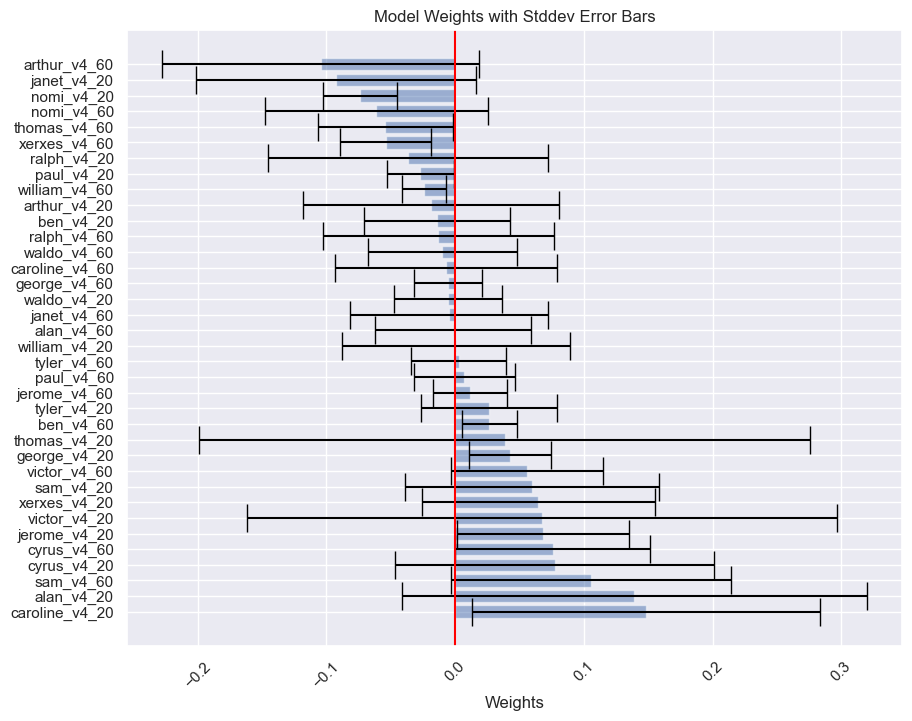

In [304]:
ft_wts = np.concatenate(
    [mdl.coef_[:, None] for mdl in hp_cv_models[0]["cv_models"]],
    axis=1,
)
mean_ft_wts = ft_wts.mean(axis=1)
std_ft_wts = ft_wts.std(axis=1)

fig, ax = plt.subplots(figsize=(10,8))
std_ix = mean_ft_wts.argsort()[::-1]
ax.barh(y=fmtd_pred_cols[std_ix], width=mean_ft_wts[std_ix], xerr=std_ft_wts[std_ix], align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_xlabel('Weights')
ax.set_title('Model Weights with Stddev Error Bars')
ax.axvline(color="red")
plt.xticks(rotation=45);